# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Flux
using Plots
using StatsBase
using MLJ: confusion_matrix

include("../../lib.jl")

ENV["LINES"]=30;

In [2]:
mkdir("./Figures")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Datasets

In [3]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


In [5]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,Class_Name,,B,,R,3,,String
2,Left_Weight,3.0,1,3.0,5,,,Int64
3,Left_Distance,3.0,1,3.0,5,,,Int64
4,Right_Weight,3.0,1,3.0,5,,,Int64
5,Right_Distance,3.0,1,3.0,5,,,Int64


Look at class labels to see if dataset is imbalanced

In [6]:
label_counts = countmap(data[:Class_Name])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [7]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [8]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [9]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [10]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [11]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [12]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [13]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [14]:
@load NeuralNetworkClassifier verbosity=2

import MLJFlux ✔
import 

┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


MLJFlux ✔


NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @538

## Neural networks
* Use favorite kind of network and training algorithm. 
* You may use networks of nodes with as many layers as you like and any activation function you see fit.

1. https://github.com/alan-turing-institute/MLJFlux.jl/blob/master/examples/boston.ipynb
1. https://github.com/alan-turing-institute/MLJFlux.jl
1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/

In [15]:
# Define a custom network
mutable struct CustomNN <:MLJFlux.Builder
    n1 ::Int
    n2 ::Int
end

In [16]:
function MLJFlux.build(nn::CustomNN, n_in, n_out)
    return Chain(
        Flux.Dense(n_in, nn.n1, σ),
        Flux.Dense(nn.n1, nn.n2, σ),
        Flux.Dense(nn.n2, n_out, σ),
    )
end

In [17]:
layer1 = 80
layer2 = 40

40

In [18]:
batch_sz = 16;

In [19]:
max_epochs = 4000;

### No-preprocessing

In [20]:
nn = NeuralNetworkClassifier(builder=CustomNN(layer1,layer2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 80,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @559

In [21]:
Net = machine(nn, X, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @945 trained 0 times.
  args: 
    1:	Source @683 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @968 ⏎ `AbstractArray{Multiclass{3},1}`


In [22]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [23]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @945.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Loss is 0.977
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9565
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9506
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9477
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9456
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9437
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9417
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.939
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.9342
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.923


Machine{NeuralNetworkClassifier{CustomNN,…}} @945 trained 1 time.
  args: 
    1:	Source @683 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @968 ⏎ `AbstractArray{Multiclass{3},1}`


In [24]:
nn.optimiser.eta = nn.optimiser.eta / 3
nn.epochs = nn.epochs + 40

100

In [25]:
fit!(Net, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{CustomNN,…}} @945.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:320
┌ Info: Loss is 0.6573
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6571
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.657
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6568
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6567
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6565
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6564
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6563
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.6561
└ @ MLJFlux /home/andrew/.julia/packages/MLJFlux/rYILg/src/core.jl:95
┌ Info: Loss is 0.656

Machine{NeuralNetworkClassifier{CustomNN,…}} @945 trained 2 times.
  args: 
    1:	Source @683 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @968 ⏎ `AbstractArray{Multiclass{3},1}`


In [26]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:09


┌───────────────┬───────────────┬───────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                        │
├───────────────┼───────────────┼───────────────────────────────────────────────────┤
│ cross_entropy │ 0.663         │ Float32[0.649, 0.693, 0.659, 0.655, 0.675, 0.648] │
│ acc           │ 0.866         │ [0.876, 0.827, 0.875, 0.885, 0.856, 0.875]        │
└───────────────┴───────────────┴───────────────────────────────────────────────────┘
_.per_observation = [[[0.589, 0.554, ..., 1.07], [0.553, 0.555, ..., 0.557], [0.557, 0.553, ..., 0.554], [0.552, 0.554, ..., 1.51], [0.553, 0.574, ..., 0.553], [1.02, 0.581, ..., 0.556]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [27]:
fitted_params(Net)

(chain = Chain(Chain(Dense(4, 80, σ), Dense(80, 40, σ), Dense(40, 3, σ)), softmax),)

In [28]:
report(Net)

(training_losses = Any[1.0465535f0, 1.009377f0, 0.9881669f0, 0.97590107f0, 0.9678866f0, 0.96199423f0, 0.9572262f0, 0.9530132f0, 0.9489472f0, 0.9446541f0  …  0.66407424f0, 0.663797f0, 0.6635255f0, 0.66325974f0, 0.6629996f0, 0.6627448f0, 0.66249514f0, 0.66225064f0, 0.6620111f0, 0.66177636f0],)

### With Preprocessing

Standardizing Inputs makes a huge difference.
Before, I could only barely break below 0.4 training loss, but by standardizing inputs, I can easily get near 0.3.

In [29]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @574.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [30]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @945 trained 0 times.
  args: 
    1:	Source @067 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @572 ⏎ `AbstractArray{Multiclass{3},1}`


### Learning Curve

In [31]:
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @945.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:28


Machine{NeuralNetworkClassifier{CustomNN,…}} @945 trained 1 time.
  args: 
    1:	Source @067 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @572 ⏎ `AbstractArray{Multiclass{3},1}`


In [32]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:02:57


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.624         │ Float32[0.64, 0.624, 0.649, 0.599, 0.615, 0.614] │
│ acc           │ 0.901         │ [0.857, 0.904, 0.865, 0.913, 0.933, 0.933]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 1.1], [0.551, 1.1, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [33]:
vals = collect(0:5:max_epochs)
r = range(nn, :epochs, lower=1, upper=max_epochs, scale=:log10)

MLJBase.NumericRange(Int64, :epochs, ... )

In [34]:
curve = MLJ.learning_curve(Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUProcesses()
)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @744.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 28 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 28 metamodels: 100%[=========================] Time: 0:00:25


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 6, 7, 10, 13, 17, 23  …  305, 406, 540, 719, 957, 1274, 1696, 2258, 3005, 4000],
 measurements = [1.1452142000198364, 1.1249732971191406, 1.1112523078918457, 1.1080005168914795, 1.0929901599884033, 1.1059246063232422, 1.0846154689788818, 1.0712698698043823, 1.0515507459640503, 1.024496078491211  …  0.6548386216163635, 0.6536785364151001, 0.6503954529762268, 0.6444751620292664, 0.6406800150871277, 0.6337181329727173, 0.6313996911048889, 0.6321199536323547, 0.622015118598938, 0.6166302561759949],)

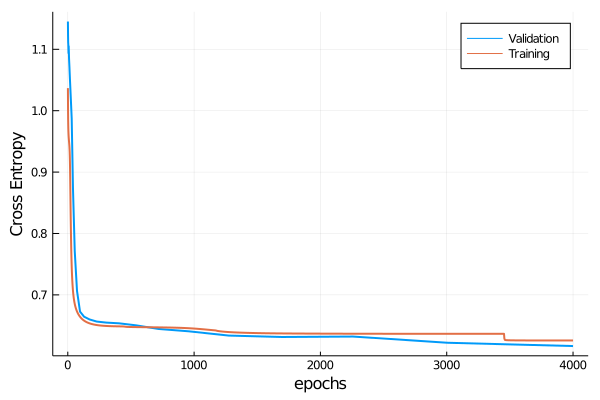

In [35]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net.report.training_losses, label="Training", lw=2)

In [36]:
a = round(nn.optimiser.eta, digits=5)
b = round(minimum(curve.measurements), digits=5)
best_epochs = curve.parameter_values[argmin(curve.measurements)]
a,b, best_epochs

(0.00033, 0.61663, 4000)

In [37]:
fn = "Figures/LearningCurve_NN_hidden:$(layer1)x$(layer2)_epochs:$(nn.epochs)_lr:$(a)_loss:$(b)_labmda:$(nn.lambda)"
png(replace(fn,'.' => ','))

### GridSearch for Hidden Layer Size 1

In [48]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @171 trained 0 times.
  args: 
    1:	Source @200 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @045 ⏎ `AbstractArray{Multiclass{3},1}`


In [49]:
param1 = :epochs
param2 = :(builder.n1)
# param2 = :(builder.n2)

r1 = range(nn, param1, lower=10, upper=4000, scale=:log10)
# r1 = range(nn, param1, lower=1, upper=100, scale=:linear)
r2 = range(nn, param2, lower=10, upper=100, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n1), ... )

In [50]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @556,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 4000,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @460, NumericRange{Int64,…} @065],
    train_best = true,
    repeats = 1,
    

In [51]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @615 trained 0 times.
  args: 
    1:	Source @682 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @609 ⏎ `AbstractArray{Multiclass{3},1}`


In [52]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @615.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:03:39


Machine{ProbabilisticTunedModel{Grid,…}} @615 trained 1 time.
  args: 
    1:	Source @682 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @609 ⏎ `AbstractArray{Multiclass{3},1}`


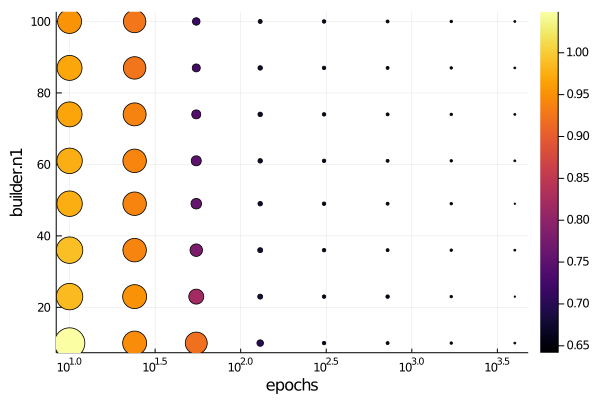

In [53]:
plot(self_tuning_nn)

In [54]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @340,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 49, σ), Dense(49, 40, σ), Dense(40, 3, σ)), softmax),),)

In [55]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.0003333333333333333, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 4000,
    batch_size = 16,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @340

In [56]:
best_loss = z.report.best_result.measurement[1]

0.64171624f0

In [57]:
best_n1 = best.best_model.builder.n1

49

In [58]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_n1)_bestloss:$(best_loss)"
f = replace(fn,'.' => ',')
png(f)

### GridSearch for Hidden Layer Size 2

In [59]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,layer2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 40),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @820

In [60]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [61]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @600 trained 0 times.
  args: 
    1:	Source @555 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @792 ⏎ `AbstractArray{Multiclass{3},1}`


In [62]:
param1 = :epochs
# param1 = :(builder.n1)
param2 = :(builder.n2)

r1 = range(nn, param1, lower=10, upper=4000, scale=:log10)
# r1 = range(nn, param1, lower=1, upper=100, scale=:linear)
r2 = range(nn, param2, lower=5, upper=best_n1, scale=:linear)

MLJBase.NumericRange(Int64, :(builder.n2), ... )

In [63]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=64),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @025,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 64,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @460, NumericRange{Int64,…} @963],
    train_best = true,
    repeats = 1,
    n = nothing,
    a

In [64]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @021 trained 0 times.
  args: 
    1:	Source @996 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @535 ⏎ `AbstractArray{Multiclass{3},1}`


In [65]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @021.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 64 metamodels: 100%[=========================] Time: 0:03:16


Machine{ProbabilisticTunedModel{Grid,…}} @021 trained 1 time.
  args: 
    1:	Source @996 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @535 ⏎ `AbstractArray{Multiclass{3},1}`


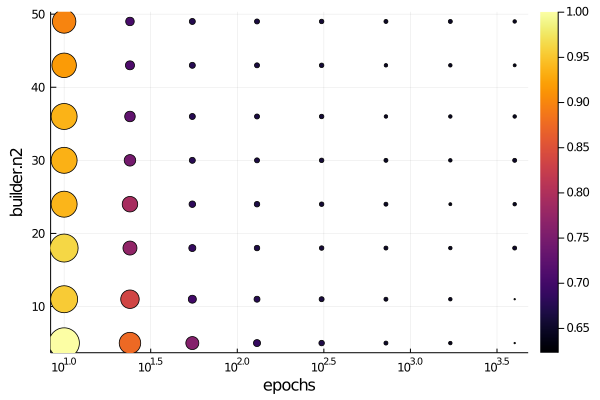

In [66]:
plot(self_tuning_nn)

In [67]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @407,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 49, σ), Dense(49, 5, σ), Dense(5, 3, σ)), softmax),),)

In [68]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 4000,
    batch_size = 16,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @407

In [69]:
best_loss = z.report.best_result.measurement[1]

0.62311363f0

In [70]:
best_n2 = best.best_model.builder.n2

5

In [71]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_n2)_bestloss:$(best_loss)"
png(replace(fn,'.' => ','))

### GridSearch for Learning Rate

In [72]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @737

In [73]:
nn.optimiser.eta = 0.001
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [74]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @384 trained 0 times.
  args: 
    1:	Source @872 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @121 ⏎ `AbstractArray{Multiclass{3},1}`


In [75]:
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @384.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:00


Machine{NeuralNetworkClassifier{CustomNN,…}} @384 trained 1 time.
  args: 
    1:	Source @872 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @121 ⏎ `AbstractArray{Multiclass{3},1}`


In [76]:
param1 = :epochs
param2 = :(optimiser.eta)

r1 = range(nn, param1, lower=10, upper=4000, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=0.1, scale=:log10)

MLJBase.NumericRange(Float64, :(optimiser.eta), ... )

In [77]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @054,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @308, NumericRange{Float64,…} @857],
    train_best = true,
    repeats = 1,
    n = nothing,

In [78]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @482 trained 0 times.
  args: 
    1:	Source @868 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @771 ⏎ `AbstractArray{Multiclass{3},1}`


In [79]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @482.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:03:07


Machine{ProbabilisticTunedModel{Grid,…}} @482 trained 1 time.
  args: 
    1:	Source @868 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @771 ⏎ `AbstractArray{Multiclass{3},1}`


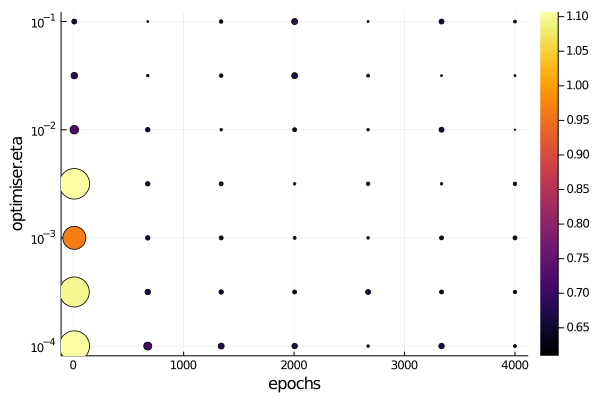

In [80]:
plot(self_tuning_nn)

In [81]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @832,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 49, σ), Dense(49, 5, σ), Dense(5, 3, σ)), softmax),),)

In [82]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 4000,
    batch_size = 16,
    lambda = 0.01,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @832

In [83]:
best_loss = z.report.best_result.measurement[1]

0.60952246f0

In [84]:
best_eta = round(best.best_model.optimiser.eta, digits=5)

0.01

In [85]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_eta)_bestloss:$(best_loss)_hidden:$b"
png(replace(fn,'.' => ','))

### GridSearch for Regularization

In [86]:
nn = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @058

In [87]:
nn.optimiser.eta = best_eta
nn.epochs = 60
nn.batch_size = batch_sz
nn.lambda = 0.01

0.01

In [88]:
Net = machine(nn, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @586 trained 0 times.
  args: 
    1:	Source @455 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @862 ⏎ `AbstractArray{Multiclass{3},1}`


In [89]:
param1 = :epochs
param2 = :lambda

r1 = range(nn, param1, lower=100, upper=4000, scale=:linear)
r2 = range(nn, param2, lower=0.0001, upper=10, scale=:log10)

MLJBase.NumericRange(Float64, :lambda, ... )

In [90]:
self_tuning_nn_model = TunedModel(model=nn,
                                    tuning=Grid(goal=50),
                                    resampling=Holdout(fraction_train=0.7), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1, r2])

ProbabilisticTunedModel(
    model = NeuralNetworkClassifier(
            builder = CustomNN @669,
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
            loss = Flux.crossentropy,
            epochs = 60,
            batch_size = 16,
            lambda = 0.01,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false),
    tuning = Grid(
            goal = 50,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{T,MLJBase.Bounded,Symbol} where T[NumericRange{Int64,…} @841, NumericRange{Float64,…} @334],
    train_best = true,
    repeats = 1,
    n = nothing,


In [91]:
self_tuning_nn = machine(self_tuning_nn_model, X_stand, y)

Machine{ProbabilisticTunedModel{Grid,…}} @314 trained 0 times.
  args: 
    1:	Source @502 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @296 ⏎ `AbstractArray{Multiclass{3},1}`


In [92]:
z = fit!(self_tuning_nn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @314.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 49 metamodels: 100%[=========================] Time: 0:05:06


Machine{ProbabilisticTunedModel{Grid,…}} @314 trained 1 time.
  args: 
    1:	Source @502 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @296 ⏎ `AbstractArray{Multiclass{3},1}`


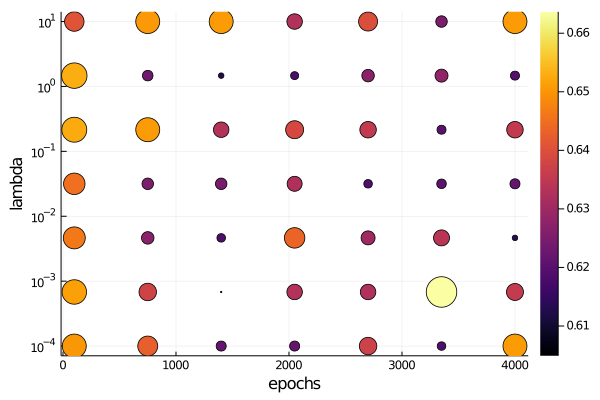

In [93]:
plot(self_tuning_nn)

In [94]:
best = fitted_params(self_tuning_nn)
best

(best_model = NeuralNetworkClassifier{CustomNN,…} @324,
 best_fitted_params = (chain = Chain(Chain(Dense(4, 49, σ), Dense(49, 5, σ), Dense(5, 3, σ)), softmax),),)

In [95]:
best.best_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 1400,
    batch_size = 16,
    lambda = 0.0006812920690579615,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @324

In [96]:
best_loss = z.report.best_result.measurement[1]

0.60491353f0

In [97]:
best_lambda = best.best_model.lambda

0.0006812920690579615

In [98]:
fn = "Figures/Grid_NN_$(param1):$(best.best_model.epochs)_x_$(param2):$(best_lambda)_bestloss:$(best_loss)"
png(replace(fn,'.' => ','))

### Learning Curve

In [99]:
lc_model = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))
lc_model.optimiser.eta = best_eta;
lc_model.lambda = best_lambda
lc_model.epochs = max_epochs
lc_model.batch_size = batch_sz
lc_model

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 4000,
    batch_size = 16,
    lambda = 0.0006812920690579615,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @968

In [100]:
# lc_model = NeuralNetworkClassifier(builder=CustomNN(80,80))
# lc_model.optimiser.eta = 0.001;
# lc_model.lambda = best_lambda
# lc_model.epochs = 3000
# lc_model.batch_size = 8

In [103]:
mce(x,y) = mean(cross_entropy(x,y))

mce (generic function with 1 method)

In [104]:
data_schedule, training_losses, valid_losses = learn_curve(lc_model, X[train,:], y[train], mce, step=5)

(d, train_metric, valid_metric) = (10, 0.55175465f0, 0.90735054f0)
(d, train_metric, valid_metric) = (15, 0.5517857f0, 0.8533822f0)
(d, train_metric, valid_metric) = (20, 0.5788382f0, 0.72008127f0)
(d, train_metric, valid_metric) = (25, 0.55146396f0, 0.7136448f0)
(d, train_metric, valid_metric) = (30, 0.5514829f0, 0.67770183f0)
(d, train_metric, valid_metric) = (35, 0.6139821f0, 0.6528931f0)
(d, train_metric, valid_metric) = (40, 0.55145013f0, 0.6649284f0)
(d, train_metric, valid_metric) = (45, 0.5514527f0, 0.6629966f0)
(d, train_metric, valid_metric) = (50, 0.5514456f0, 0.66460997f0)
(d, train_metric, valid_metric) = (55, 0.5514457f0, 0.66499937f0)
(d, train_metric, valid_metric) = (60, 0.55144554f0, 0.68097883f0)
(d, train_metric, valid_metric) = (65, 0.55144495f0, 0.61828834f0)
(d, train_metric, valid_metric) = (70, 0.5514449f0, 0.631122f0)
(d, train_metric, valid_metric) = (75, 0.56477815f0, 0.63158756f0)
(d, train_metric, valid_metric) = (80, 0.5514448f0, 0.61973184f0)
(d, train_m

(10:5:350, Any[0.55175465f0, 0.5517857f0, 0.5788382f0, 0.55146396f0, 0.5514829f0, 0.6139821f0, 0.55145013f0, 0.5514527f0, 0.5514456f0, 0.5514457f0  …  0.554723f0, 0.55144423f0, 0.5546191f0, 0.554569f0, 0.55452156f0, 0.60118705f0, 0.5988112f0, 0.5602681f0, 0.602607f0, 0.59834665f0], Any[0.90735054f0, 0.8533822f0, 0.72008127f0, 0.7136448f0, 0.67770183f0, 0.6528931f0, 0.6649284f0, 0.6629966f0, 0.66460997f0, 0.66499937f0  …  0.5968993f0, 0.59687144f0, 0.5908252f0, 0.58797306f0, 0.5966907f0, 0.592176f0, 0.5955035f0, 0.59741527f0, 0.5956202f0, 0.58545643f0])

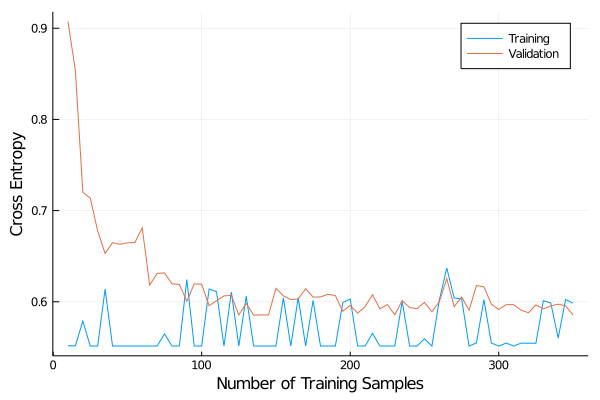

In [107]:
plot(data_schedule, training_losses, label="Training")
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Cross Entropy")

In [108]:
png("Figures/loss_curve_NN")

#### Learning Curve

In [109]:
Net = machine(lc_model, X_stand, y)
Net.model.epochs = max_epochs
fit!(Net, rows=train, verbosity=1, force=true)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @791.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:20


Machine{NeuralNetworkClassifier{CustomNN,…}} @791 trained 1 time.
  args: 
    1:	Source @107 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @964 ⏎ `AbstractArray{Multiclass{3},1}`


In [110]:
nn_acc = evaluate!(Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:02:06


┌───────────────┬───────────────┬───────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                        │
├───────────────┼───────────────┼───────────────────────────────────────────────────┤
│ cross_entropy │ 0.577         │ Float32[0.558, 0.572, 0.561, 0.571, 0.588, 0.611] │
│ acc           │ 0.973         │ [0.99, 0.981, 0.99, 0.981, 0.962, 0.933]          │
└───────────────┴───────────────┴───────────────────────────────────────────────────┘
_.per_observation = [[[0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.556], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.855, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [111]:
r = range(nn, :epochs, lower=1, upper=max_epochs, scale=:log10)

MLJBase.NumericRange(Int64, :epochs, ... )

In [112]:
curve = MLJ.learning_curve(Net, 
                        range=r, 
                        resampling=Holdout(fraction_train=0.7), 
#                         resampling=CV(nfolds=4), 
                        measure=cross_entropy, 
                        acceleration=CPUProcesses(),
                        resolution=200
)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @011.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 147 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 147 metamodels: 100%[=========================] Time: 0:00:18


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2749, 2866, 2988, 3115, 3248, 3386, 3530, 3680, 3837, 4000],
 measurements = [1.144365906715393, 1.1488560438156128, 1.1440534591674805, 1.125603437423706, 1.039614200592041, 0.9025471806526184, 0.8521921634674072, 0.8018137812614441, 0.7746290564537048, 0.7525851130485535  …  0.6394069194793701, 0.6381062269210815, 0.638211727142334, 0.6402894258499146, 0.6406204104423523, 0.6417611241340637, 0.6359323263168335, 0.6395517587661743, 0.6380242705345154, 0.6387748122215271],)

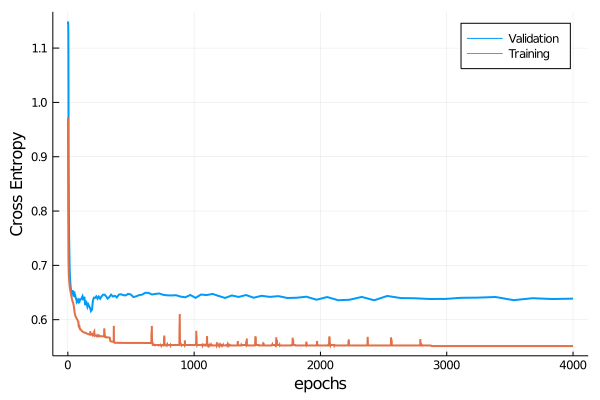

In [113]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2)
plot!(Net.report.training_losses, label="Training", lw=2)

In [114]:
best_epochs = curve.parameter_values[argmin(curve.measurements)]

183

In [115]:
png("Figures/learning_curve_nn_$(best_epochs)epochs_balance")

# Final Results

In [116]:
final_model = NeuralNetworkClassifier(builder=CustomNN(best_n1,best_n2))

NeuralNetworkClassifier(
    builder = CustomNN(
            n1 = 49,
            n2 = 5),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @179

In [117]:
final_model.optimiser.eta = lc_model.optimiser.eta = best_eta;
final_model.batch_size = batch_sz
final_model.lambda = best_lambda
final_model.epochs = best_epochs

183

In [118]:
final_model = NeuralNetworkClassifier(builder=CustomNN(80,80))
final_model.optimiser.eta = 0.01;
final_model.lambda = 0.1
final_model.epochs = best_epochs
final_model.batch_size = batch_sz

16

### Test Performance

In [119]:
Final_Net = machine(final_model, X_stand, y)

Machine{NeuralNetworkClassifier{CustomNN,…}} @139 trained 0 times.
  args: 
    1:	Source @919 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @570 ⏎ `AbstractArray{Multiclass{3},1}`


In [120]:
fit!(Final_Net, rows=train, force=true, verbosity=1)

┌ Info: Training Machine{NeuralNetworkClassifier{CustomNN,…}} @139.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Optimising neural net:100%[=========================] Time: 0:00:01


Machine{NeuralNetworkClassifier{CustomNN,…}} @139 trained 1 time.
  args: 
    1:	Source @919 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @570 ⏎ `AbstractArray{Multiclass{3},1}`


In [121]:
nn_acc = evaluate!(Final_Net, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:10


┌───────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                       │
├───────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy │ 0.622         │ Float32[0.666, 0.635, 0.61, 0.617, 0.604, 0.602] │
│ acc           │ 0.93          │ [0.886, 0.933, 0.952, 0.913, 0.952, 0.942]       │
└───────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.583, 0.592, ..., 0.551], [0.551, 0.551, ..., 0.551], [1.1, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [0.551, 0.551, ..., 0.551], [1.4, 0.551, ..., 0.551]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [122]:
ŷ = MLJ.predict(Final_Net, X_stand[test,:]);

In [123]:
cross_entropy(ŷ, y[test]) |> mean

0.5699068f0

In [124]:
acc(ŷ, y[test])

0.9786096256684492

In [125]:
confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │     15      │      3      │      1      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      0      │     83      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      0      │      0      │     85      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [126]:
fitted_params(Final_Net)

(chain = Chain(Chain(Dense(4, 80, σ), Dense(80, 80, σ), Dense(80, 3, σ)), softmax),)

In [127]:
report(Final_Net)

(training_losses = Any[0.9318212f0, 0.929488f0, 0.68552196f0, 0.65384895f0, 0.64534366f0, 0.64334077f0, 0.642639f0, 0.64177704f0, 0.6411796f0, 0.64074033f0  …  0.5693845f0, 0.56479627f0, 0.60313815f0, 0.575519f0, 0.5702296f0, 0.5679993f0, 0.564595f0, 0.56365746f0, 0.5637388f0, 0.56329715f0],)